In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!nvcc --version
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu124
!pip install  dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
!pip install torchmetrics

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
Looking in indexes: https://download.pytorch.org/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 87.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.4/883.4 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.0/363.0 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
 

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Using device: cuda
Initializing dataset...
Building character vocabulary...
Vocabulary size: 285 (characters including spaces)
Creating character-based graphs without duplicates...
Total graphs created: 258113
Dataset initialization complete.


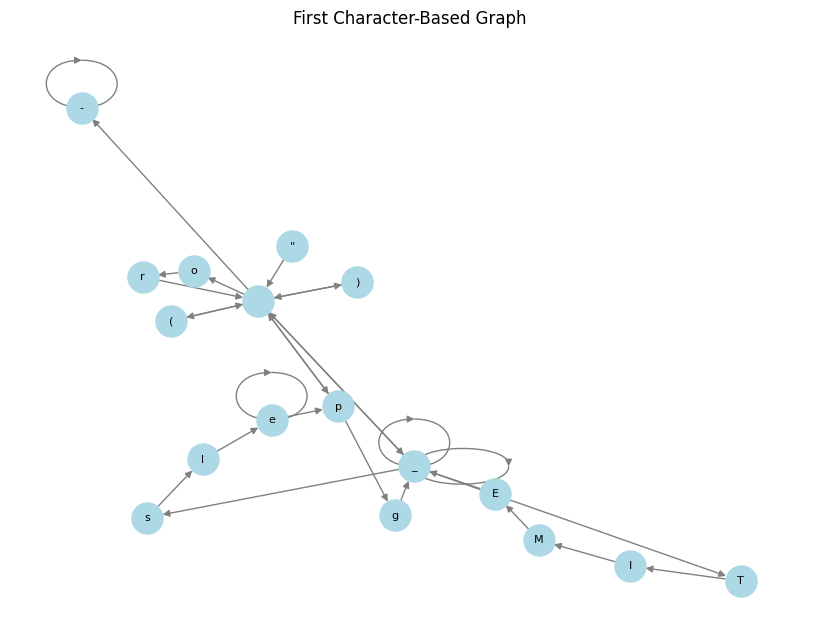

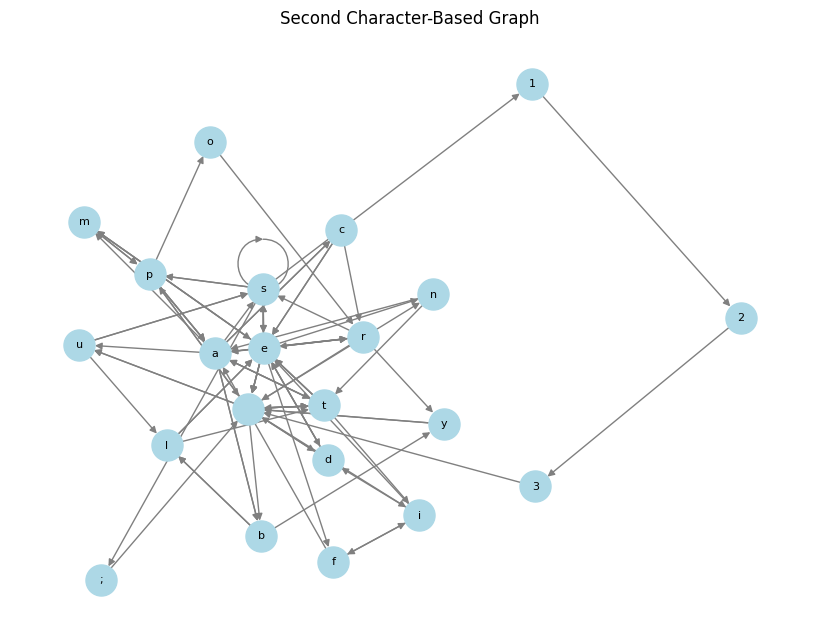

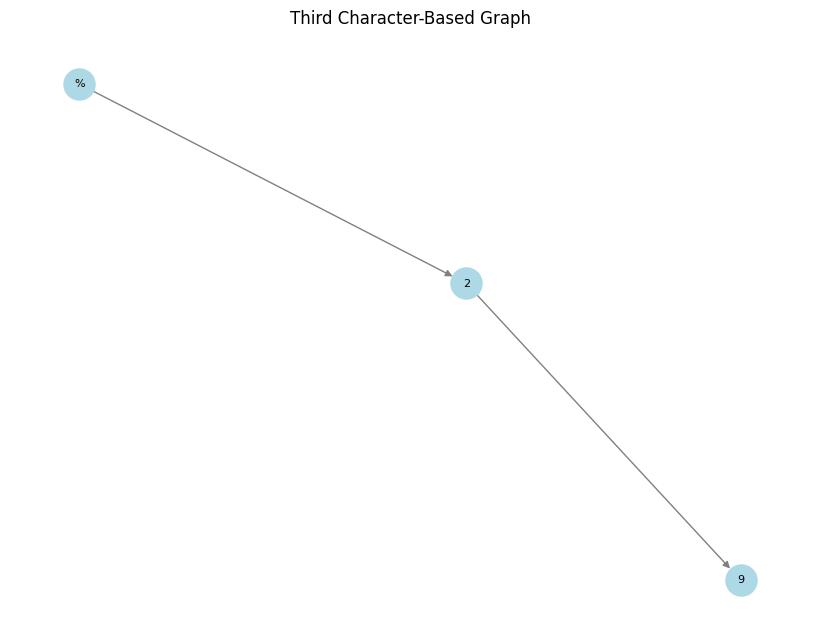

In [4]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dgl
import json
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import GraphConv
import networkx as nx
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GCN/dataset_v2.csv", on_bad_lines='skip', engine='python')

# Handle missing values
df["Payload"] = df["Payload"].fillna("").astype(str)
df["Label"] = pd.to_numeric(df["Label"], errors="coerce").fillna(0).astype(int)

# Graph dataset class (Character-Level with No Duplicates)
class CharInjectionDataset:
    def __init__(self, df):
        print("Initializing dataset...")
        self.df = df
        self.vocab = {}
        self._build_vocab()
        self.graphs, self.labels = self._create_graphs()
        print("Dataset initialization complete.")

    def _build_vocab(self):
        print("Building character vocabulary...")
        unique_chars = set("".join(self.df["Payload"]))  # Extract all unique characters
        self.vocab = {char: idx for idx, char in enumerate(unique_chars)}
        print(f"Vocabulary size: {len(self.vocab)} (characters including spaces)")

    def _create_graphs(self):
        print("Creating character-based graphs without duplicates...")
        graphs, labels = [], []

        for payload, label in zip(self.df["Payload"], self.df["Label"]):
            chars = list(payload)  # Convert payload into character list

            # Create a mapping to ensure unique nodes
            char_map = {}
            node_idx = 0

            for char in chars:
                if char not in char_map:
                    char_map[char] = node_idx
                    node_idx += 1

            num_nodes = len(char_map)
            g = dgl.graph(([], []))
            g.add_nodes(num_nodes)

            # Assign features (character indices)
            char_ids = [self.vocab[char] for char in char_map.keys()]
            g.ndata["feat"] = torch.tensor(char_ids, dtype=torch.long).unsqueeze(1)

            # Create edges based on sequence (first occurrence only)
            src, dst = [], []
            for i in range(len(chars) - 1):
                if chars[i] in char_map and chars[i + 1] in char_map:
                    src.append(char_map[chars[i]])
                    dst.append(char_map[chars[i + 1]])

            g.add_edges(src, dst)
            graphs.append(g)
            labels.append(label)

        print(f"Total graphs created: {len(graphs)}")
        return graphs, torch.tensor(labels, dtype=torch.long, device=device)

# Create dataset
dataset = CharInjectionDataset(df)
graphs = dataset.graphs
labels = dataset.labels

# Save vocabulary
with open("char_vocab.json", "w") as f:
    json.dump(dataset.vocab, f)

# Function to visualize a graph
def plot_graph(g, vocab, title="Character Graph"):
    g = g.cpu()
    nx_g = g.to_networkx()

    pos = nx.spring_layout(nx_g)
    node_labels = {i: list(vocab.keys())[list(vocab.values()).index(g.ndata["feat"][i].item())] for i in range(g.num_nodes())}

    plt.figure(figsize=(8, 6))
    nx.draw(nx_g, pos, with_labels=True, labels=node_labels, node_size=500, node_color="lightblue", edge_color="gray", font_size=8)
    plt.title(title)
    plt.show()

# Plot example graphs
plot_graph(graphs[0], dataset.vocab, title="First Character-Based Graph")
plot_graph(graphs[1], dataset.vocab, title="Second Character-Based Graph")
plot_graph(graphs[2], dataset.vocab, title="Third Character-Based Graph")


In [8]:
from sklearn.model_selection import train_test_split
from dgl.dataloading import GraphDataLoader

# Split dataset (fixed stratification)
print("Splitting dataset...")
train_graphs, test_graphs, train_labels, test_labels = train_test_split(
    graphs, labels.cpu(), test_size=0.2, random_state=42, stratify=labels.cpu()
)

print(f"Training samples: {len(train_graphs)}, Test samples: {len(test_graphs)}")

# Create data loaders
batch_size = 32
print("Creating data loaders...")
train_loader = GraphDataLoader(
    list(zip(train_graphs, train_labels)), batch_size=batch_size, shuffle=True
)
test_loader = GraphDataLoader(
    list(zip(test_graphs, test_labels)), batch_size=batch_size
)
print("Data loaders ready.")

# GCN Model with improvements
class GCNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2, dropout=0.6):
        super().__init__()
        print("Initializing Improved GCN model...")

        self.embed = nn.Embedding(vocab_size, embed_dim)

        # Three GraphConv layers for better feature extraction
        self.conv1 = GraphConv(embed_dim, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True)
        self.conv3 = GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True)

        # Batch Normalization to stabilize training
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        print("Model initialized.")

    def forward(self, g):
        h = self.embed(g.ndata["feat"].squeeze(1).to(self.embed.weight.device))
        h = F.relu(self.bn1(self.conv1(g, h)))
        h = F.relu(self.bn2(self.conv2(g, h)))
        h = F.relu(self.bn3(self.conv3(g, h)))

        with g.local_scope():
            g.ndata["h"] = h
            hg = dgl.mean_nodes(g, "h")

        hg = self.dropout(F.relu(self.fc1(hg)))
        return self.fc2(hg)

# Training setup
print("Setting up training...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCNClassifier(len(dataset.vocab)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-4, eps=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
criterion = nn.CrossEntropyLoss()
print("Training setup complete.")

Splitting dataset...
Training samples: 206490, Test samples: 51623
Creating data loaders...
Data loaders ready.
Setting up training...
Initializing Improved GCN model...
Model initialized.
Training setup complete.


Using device: cuda
Starting training...
Epoch 1/10 started...


Epoch 1/10: 100%|██████████| 6453/6453 [01:24<00:00, 76.19it/s, loss=0.14]


Epoch 1 | Loss: 0.1401 | Train Acc: 97.40% | Val Acc: 97.29%
New best model saved with Val Acc: 97.29%
Epoch 2/10 started...


Epoch 2/10: 100%|██████████| 6453/6453 [01:15<00:00, 85.82it/s, loss=0.0899]


Epoch 2 | Loss: 0.0899 | Train Acc: 96.87% | Val Acc: 96.77%
Epoch 3/10 started...


Epoch 3/10: 100%|██████████| 6453/6453 [01:16<00:00, 84.49it/s, loss=0.0804]


Epoch 3 | Loss: 0.0804 | Train Acc: 97.07% | Val Acc: 96.71%
Epoch 4/10 started...


Epoch 4/10: 100%|██████████| 6453/6453 [01:16<00:00, 84.13it/s, loss=0.0757]


Epoch 4 | Loss: 0.0757 | Train Acc: 97.66% | Val Acc: 97.45%
New best model saved with Val Acc: 97.45%
Epoch 5/10 started...


Epoch 5/10: 100%|██████████| 6453/6453 [01:16<00:00, 84.18it/s, loss=0.0717]


Epoch 5 | Loss: 0.0717 | Train Acc: 98.21% | Val Acc: 97.93%
New best model saved with Val Acc: 97.93%
Epoch 6/10 started...


Epoch 6/10: 100%|██████████| 6453/6453 [01:18<00:00, 81.89it/s, loss=0.0693]


Epoch 6 | Loss: 0.0693 | Train Acc: 97.87% | Val Acc: 97.64%
Epoch 7/10 started...


Epoch 7/10: 100%|██████████| 6453/6453 [01:16<00:00, 84.47it/s, loss=0.0678]


Epoch 7 | Loss: 0.0678 | Train Acc: 98.34% | Val Acc: 98.11%
New best model saved with Val Acc: 98.11%
Epoch 8/10 started...


Epoch 8/10: 100%|██████████| 6453/6453 [01:16<00:00, 84.85it/s, loss=0.0651]


Epoch 8 | Loss: 0.0651 | Train Acc: 98.37% | Val Acc: 98.11%
New best model saved with Val Acc: 98.11%
Epoch 9/10 started...


Epoch 9/10: 100%|██████████| 6453/6453 [01:15<00:00, 85.94it/s, loss=0.0642]


Epoch 9 | Loss: 0.0642 | Train Acc: 98.36% | Val Acc: 98.10%
Epoch 10/10 started...


Epoch 10/10: 100%|██████████| 6453/6453 [01:16<00:00, 84.84it/s, loss=0.0632]


Epoch 10 | Loss: 0.0632 | Train Acc: 98.23% | Val Acc: 97.99%
Training complete. Best model saved as /content/gcn_model_v3.pth with accuracy 98.11%
Evaluating model on test set...


Final Test Accuracy: 97.99%


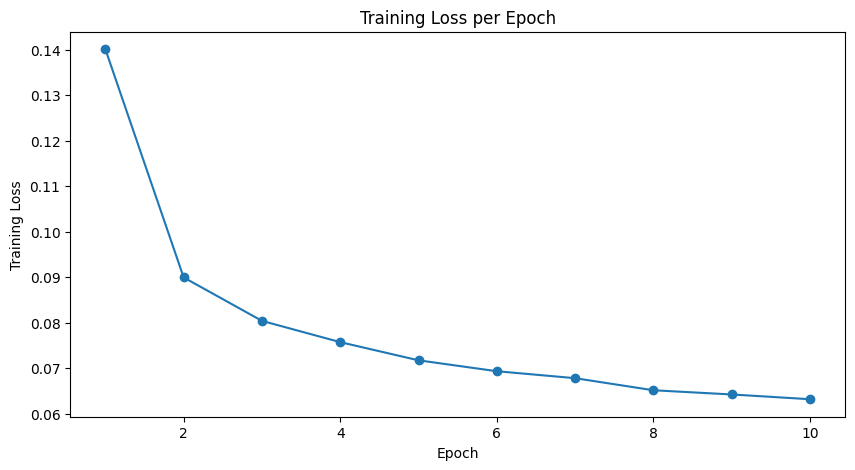

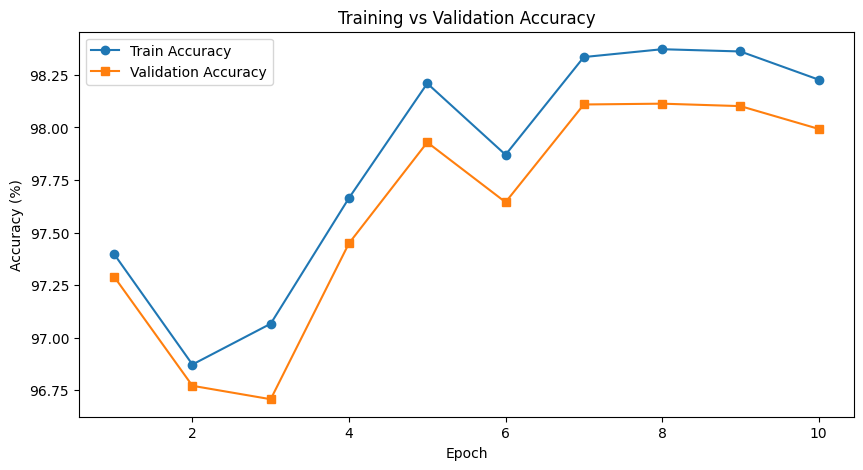

In [9]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.dataloading import GraphDataLoader
from dgl.nn import GraphConv
from tqdm import tqdm
import networkx as nx
from torchmetrics.classification import Accuracy

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize Accuracy Metric
accuracy_metric = Accuracy(task="multiclass", num_classes=2).to(device)

# Function to compute accuracy with tqdm progress bar
def compute_accuracy(model, loader):
    model.eval()
    accuracy_metric.reset()

    with torch.no_grad():
        progress_bar = tqdm(loader, desc="Evaluating", leave=False)
        for batched_graphs, batched_labels in progress_bar:
            batched_graphs = batched_graphs.to(device)
            batched_labels = batched_labels.to(device).long()

            logits = model(batched_graphs)
            predicted = torch.argmax(logits, dim=1)

            accuracy_metric.update(predicted, batched_labels)

    return accuracy_metric.compute().item() * 100  # Convert to percentage


# Training loop with tqdm
num_epochs = 10
train_losses = []
train_accs = []
val_accs = []
best_val_acc = 0.0
best_model_path = "/content/gcn_model_v3.pth"

print("Starting training...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs} started...")
    model.train()
    total_loss = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)

    for batched_graphs, batched_labels in progress_bar:
        batched_graphs = batched_graphs.to(device)
        batched_labels = batched_labels.to(device).long()

        logits = model(batched_graphs)
        loss = criterion(logits, batched_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=total_loss / len(train_loader))

    train_loss = total_loss / len(train_loader)
    train_acc = compute_accuracy(model, train_loader)
    val_acc = compute_accuracy(model, test_loader)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved with Val Acc: {best_val_acc:.2f}%")

print(f"Training complete. Best model saved as {best_model_path} with accuracy {best_val_acc:.2f}%")

# Final evaluation
print("Evaluating model on test set...")
test_accuracy = compute_accuracy(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

# Plot training loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.show()

# Plot accuracy trends
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accs, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs + 1), val_accs, label="Validation Accuracy", marker='s')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()


Confusion Matrix:
 [[21869   131]
 [  905 28718]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9603    0.9940    0.9769     22000
           1     0.9955    0.9694    0.9823     29623

    accuracy                         0.9799     51623
   macro avg     0.9779    0.9817    0.9796     51623
weighted avg     0.9805    0.9799    0.9800     51623



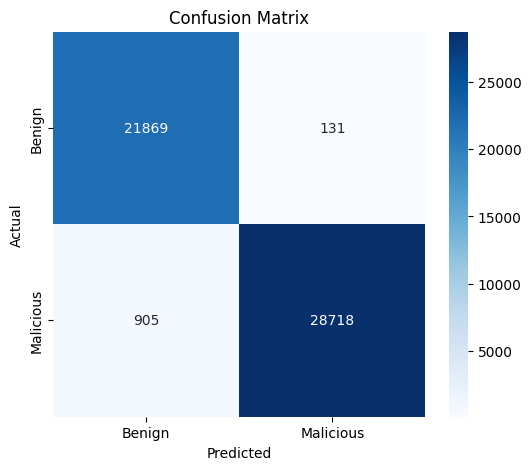

In [10]:
# Assuming you have a test dataset: test_graphs, test_labels
def evaluate_model(model, test_graphs, test_labels):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for g, label in zip(test_graphs, test_labels):
            g = g.to(device)
            label = label.item()
            logits = model(g)
            probs = torch.softmax(logits, dim=1)
            pred_label = torch.argmax(probs, dim=1).item()

            y_true.append(label)
            y_pred.append(pred_label)

    # Compute Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)

    # Compute Precision, Recall, and F1-score
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

    # Plot Confusion Matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Call the function to evaluate
evaluate_model(model, test_graphs, test_labels)


In [32]:
import torch
import json
import torch.nn as nn
import torch.nn.functional as F
import dgl
from dgl.nn import GraphConv

# Define GCN model
class GCNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2, dropout=0.6):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        self.conv1 = GraphConv(embed_dim, hidden_dim, allow_zero_in_degree=True)
        self.conv2 = GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True)
        self.conv3 = GraphConv(hidden_dim, hidden_dim, allow_zero_in_degree=True)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = nn.Linear(hidden_dim // 2, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g):
        h = self.embed(g.ndata["feat"].squeeze(1))
        h = F.relu(self.bn1(self.conv1(g, h)))
        h = F.relu(self.bn2(self.conv2(g, h)))
        h = F.relu(self.bn3(self.conv3(g, h)))
        with g.local_scope():
            g.ndata["h"] = h
            hg = dgl.mean_nodes(g, "h")
        hg = self.dropout(F.relu(self.fc1(hg)))
        return self.fc2(hg)

# Load vocabulary
with open("/content/drive/MyDrive/Colab Notebooks/GCN/char_vocab.json", "r") as f:
    vocab = json.load(f)

vocab_size = len(vocab)

# Force CPU usage
device = torch.device("cpu")

# Initialize and load model on CPU
model = GCNClassifier(vocab_size).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/GCN/gcn_model_v3.pth", map_location=device,weights_only=True))

model.eval()

print("Model loaded successfully and ready for inference.")

# Function to convert payload to graph
# Function to convert payload to graph
def preprocess_payload(payload, vocab):
    if not payload:  # Handle empty payloads
        return dgl.graph(([], []), num_nodes=1)

    chars = list(payload)  # Keep character sequence
    num_nodes = len(chars)

    g = dgl.graph(([], []))
    g.add_nodes(num_nodes)

    # Assign features (character embeddings)
    char_ids = [vocab.get(c, 0) for c in chars]  # Unknown chars get ID 0
    g.ndata["feat"] = torch.tensor(char_ids, dtype=torch.long).unsqueeze(1)

    # Create directed edges (bi-directional for better context)
    src = list(range(num_nodes - 1))
    dst = list(range(1, num_nodes))

    g.add_edges(src, dst)  # Forward edges
    g.add_edges(dst, src)  # Backward edges

    return g

# Prediction function
def predict(payload):
    g = preprocess_payload(payload, vocab)
    g = g.to(device)

    with torch.no_grad():
        logits = model(g)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred_label = int(probs.argmax(axis=1)[0])  # Get class label
        confidence = float(probs[0][pred_label])   # Get confidence score

    return pred_label, confidence

# Example usage
payload = "admin123"
label, confidence = predict(payload)
print(f"Predicted Class: {label}, Confidence: {confidence:.5f}")


Model loaded successfully and ready for inference.
Predicted Class: 0, Confidence: 0.99969
